In [1]:
import os  # noqa
import sys  # noqa

proj_root = os.path.dirname(os.getcwd())
sys.path.append(proj_root)

OBJ_NAME = "mustard_bottle"

obj_dir = os.path.join(proj_root, "data", "objects", OBJ_NAME)
obj_path = os.path.join(obj_dir, "textured_simple.obj")
ply_path = os.path.join(obj_dir, "textured.ply")
texture_path = os.path.join(obj_dir, "texture_map.png")

In [2]:
import os
import torch
import matplotlib.pyplot as plt

# Util function for loading meshes
from pytorch3d.io import load_objs_as_meshes, load_obj

# Data structures and functions for rendering
from pytorch3d.structures import Meshes
from pytorch3d.vis.plotly_vis import AxisArgs, plot_batch_individually, plot_scene
from pytorch3d.vis.texture_vis import texturesuv_image_matplotlib
from pytorch3d.renderer import (
    look_at_view_transform,
    FoVPerspectiveCameras,
    PerspectiveCameras,
    PointLights,
    DirectionalLights,
    Materials,
    RasterizationSettings,
    MeshRenderer,
    MeshRasterizer,
    SoftPhongShader,
    TexturesUV,
    TexturesVertex,
    BlendParams,
)
from pytorch3d.transforms import matrix_to_quaternion
from scipy.spatial import ConvexHull
import numpy as np

from posingpixels.utils.meshes import get_diameter_from_vertices

# add path for demo utils functions
import sys
import os

sys.path.append(os.path.abspath(""))

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [3]:
# mesh = load_objs_as_meshes([obj_path], device=device)

# plt.figure(figsize=(7, 7))
# texture_image = mesh.textures.maps_padded()
# plt.imshow(texture_image.squeeze().cpu().numpy())
# plt.axis("off");

In [4]:
def create_camera_from_intrinsics(R, T, K, image_size, device="cpu"):
    """
    Create a PyTorch3D camera from a 3x3 intrinsic matrix K.

    Args:
        R (torch.Tensor): 3x3 rotation matrix
        T (torch.Tensor): 3x1 translation vector
        K (torch.Tensor or numpy.ndarray): 3x3 camera intrinsic matrix
        image_size (tuple): (height, width) of the image
        device (str): Device to place the camera on

    Returns:
        PerspectiveCameras: PyTorch3D camera object
    """
    if isinstance(K, np.ndarray):
        K = torch.from_numpy(K).float()

    # Extract focal length and principal point
    fx, fy = K[0, 0], K[1, 1]
    cx, cy = K[0, 2], K[1, 2]

    # Convert to PyTorch3D format
    # PyTorch3D expects focal length to be normalized by image size
    height, width = image_size
    focal_length = torch.tensor([[fx / width, fy / height]], device=device)

    # Principal point needs to be converted from pixels to NDC space (-1 to 1)
    principal_point = torch.tensor(
        [[2 * cx / width - 1, 2 * cy / height - 1]], device=device
    )

    # Create camera
    cameras = PerspectiveCameras(
        R=R,
        T=T,
        focal_length=focal_length,
        principal_point=principal_point,
        in_ndc=True,
        device=device,
    )

    return cameras


def create_renderer_with_depth(
    cameras,
    image_size=(256, 256),
    device="cpu",
    background_color=(0, 0, 0),
    blur_radius=0.0,
    faces_per_pixel=1,
):
    """
    Create a renderer that returns RGB, alpha values, and depth information.

    Args:
        cameras: PyTorch3D cameras
        image_size: Tuple of (height, width)
        device: Device to place the renderer on
        background_color: RGB background color
        blur_radius: Blur radius for soft rasterization
        faces_per_pixel: Number of faces to rasterize per pixel
    """
    # Rasterization settings
    raster_settings = RasterizationSettings(
        image_size=image_size,
        blur_radius=blur_radius,
        faces_per_pixel=faces_per_pixel,
    )

    # Create a blend params object that includes alpha computation
    blend_params = BlendParams(background_color=background_color)

    # Create rasterizer and shader
    rasterizer = MeshRasterizer(cameras=cameras, raster_settings=raster_settings)

    shader = SoftPhongShader(device=device, cameras=cameras, blend_params=blend_params)

    # Create renderer
    renderer = MeshRenderer(rasterizer=rasterizer, shader=shader)

    return renderer, rasterizer


def render_mesh_with_depth(mesh, renderer, rasterizer):
    """
    Render a mesh and return RGB, alpha values, and depth information.

    Args:
        mesh: PyTorch3D mesh object
        renderer: PyTorch3D renderer
        rasterizer: PyTorch3D rasterizer

    Returns:
        tuple: (rgb_image, alpha_mask, depth_map)
    """
    # Get the output from the rasterizer
    fragments = rasterizer(mesh)

    # Get depth from the fragments
    zbuf = fragments.zbuf  # Shape: (B, H, W, faces_per_pixel)
    # Take the closest depth value for each pixel
    depth = zbuf[..., 0]  # Shape: (B, H, W)

    # Render the full image (RGB + alpha)
    output = renderer(mesh)

    # Split the output into RGB and alpha
    rgb = output[..., :3]  # Shape: (B, H, W, 3)
    alpha = output[..., 3]  # Shape: (B, H, W)

    return rgb, alpha, depth


def invert_transform(R_obj2cam, t_obj2cam):
    """
    Convert object-to-camera transform to camera-to-object transform

    Args:
        R_obj2cam: 3x3 rotation matrix of object relative to camera
        t_obj2cam: 3x1 translation vector of object relative to camera

    Returns:
        R_cam2obj: 3x3 rotation matrix of camera relative to object
        t_cam2obj: 3x1 translation vector of camera relative to object
    """
    # For rotation: inverse = transpose
    R_cam2obj = R_obj2cam.T

    # For translation: t_cam2obj = -R_cam2obj @ t_obj2cam
    t_cam2obj = -R_cam2obj @ t_obj2cam

    return R_cam2obj, t_cam2obj


def transform_mesh(mesh, R, T):
    """
    Transform a mesh using rotation matrix R and translation vector T.

    Args:
        mesh: PyTorch3D mesh object
        R: Rotation matrix of shape (3, 3) or (B, 3, 3)
        T: Translation vector of shape (3,) or (B, 3)

    Returns:
        transformed_mesh: New PyTorch3D mesh object
    """
    # Ensure inputs are tensors
    if not torch.is_tensor(R):
        R = torch.tensor(R, dtype=torch.float32)
    if not torch.is_tensor(T):
        T = torch.tensor(T, dtype=torch.float32)

    # Add batch dimension if necessary
    if R.dim() == 2:
        R = R.unsqueeze(0)
    if T.dim() == 1:
        T = T.unsqueeze(0)

    # Get mesh vertices
    verts = mesh.verts_padded()

    # Apply rotation
    transformed_verts = torch.bmm(verts, R.transpose(-2, -1))

    # Apply translation
    transformed_verts = transformed_verts + T.unsqueeze(1)

    # Create new mesh with transformed vertices
    new_mesh = mesh.update_padded(new_verts_padded=transformed_verts)

    return new_mesh

tensor([[ 0.6202, -0.2515,  0.7436],
        [-0.7689, -0.3818,  0.5122],
        [ 0.1561, -0.8886, -0.4312]], device='cuda:0')
tensor([ 0.4490, -0.7799,  0.3271, -0.2884], device='cuda:0')
Bin size was too small in the coarse rasterization phase. This caused an overflow, meaning output may be incomplete. To solve, try increasing max_faces_per_bin / max_points_per_bin, decreasing bin_size, or setting bin_size to 0 to use the naive rasterization.Bin size was too small in the coarse rasterization phase. This caused an overflow, meaning output may be incomplete. To solve, try increasing max_faces_per_bin / max_points_per_bin, decreasing bin_size, or setting bin_size to 0 to use the naive rasterization.Bin size was too small in the coarse rasterization phase. This caused an overflow, meaning output may be incomplete. To solve, try increasing max_faces_per_bin / max_points_per_bin, decreasing bin_size, or setting bin_size to 0 to use the naive rasterization.Bin size was too small in the co

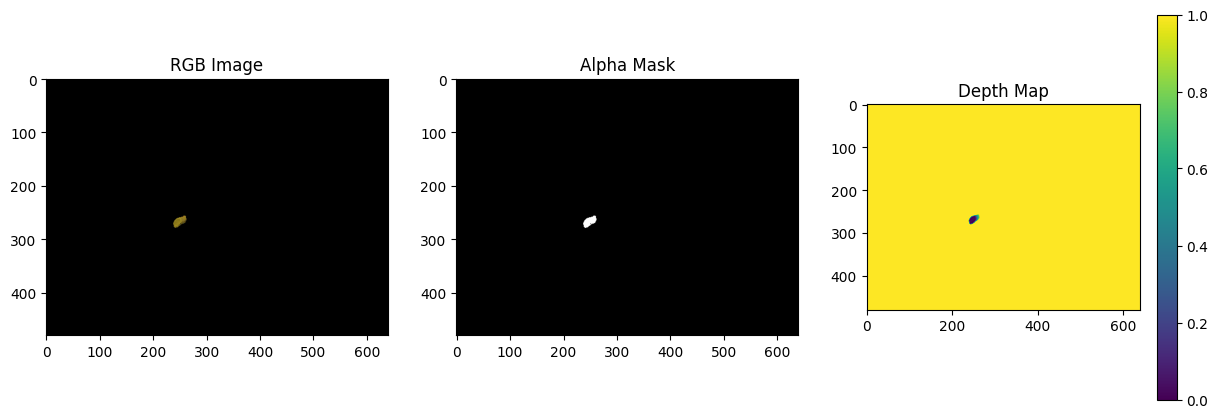

In [5]:
# Example of how to use these functions
if __name__ == "__main__":
    # Assume we have cameras and a mesh already defined
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Load mesh
    mesh = load_objs_as_meshes([obj_path], device=device)
    diameter = get_diameter_from_vertices(mesh.verts_list()[0])

    # Create cameras
    image_size = (480, 640)
    # R, T = look_at_view_transform(0.2, 0, 180)
    # print(R.shape, T.shape)
    # Object pose
    R_obj = torch.tensor(
        [
            [
                6.202282593860970472e-01,
                -2.515007418449344834e-01,
                7.435574896872494399e-01,
            ],
            [
                -7.688537710018328308e-01,
                -3.817847309062720740e-01,
                5.121920340703911556e-01,
            ],
            [
                1.560719472310490019e-01,
                -8.885882238750235640e-01,
                -4.312162231485986985e-01,
            ],
        ]
    ).to(device)
    print(R_obj)
    print(matrix_to_quaternion(R_obj))
    T_obj = torch.tensor(
        [-4.485767581348126254e-01, 1.178510214030554226e-01, 8.033601713736024941e-01]
    ).to(device)

    R_idx = torch.eye(3).to(device)
    T_idx = torch.tensor([0, 0, 0]).to(device)

    M = torch.eye(3).to(device)
    M[0, 0] = -1
    M[1, 1] = -1

    K = torch.tensor(
        [
            [3.195820007324218750e02, 0.0, 3.202149847676955687e02],
            [0.0, 4.171186828613281250e02, 2.443486680871046701e02],
            [0.0, 0.0, 1.0],
        ]
    ).to(device)
    cameras = create_camera_from_intrinsics(
        R_idx[None], T_idx[None], K, image_size=image_size, device=device
    )

    transform = cameras.get_world_to_view_transform()

    # Create renderer
    renderer, rasterizer = create_renderer_with_depth(
        cameras=cameras,
        image_size=image_size,
        device=device,
        background_color=(0, 0, 0),
        blur_radius=0.0,
        faces_per_pixel=1,
    )

    # Render mesh
    mesh_transformed = transform_mesh(mesh, R_idx, M @ T_obj)
    rgb_images, alpha_masks, depth_maps = render_mesh_with_depth(
        mesh_transformed, renderer, rasterizer
    )

    # Visualization example
    import matplotlib.pyplot as plt
    import numpy as np

    plt.figure(figsize=(15, 5))

    plt.subplot(1, 3, 1)
    plt.imshow(rgb_images[0].cpu().numpy())
    plt.title("RGB Image")

    plt.subplot(1, 3, 2)
    plt.imshow(alpha_masks[0].cpu().numpy(), cmap="gray")
    plt.title("Alpha Mask")

    # Normalize depth for visualization
    depth_vis = depth_maps[0].cpu().numpy()
    valid_mask = depth_vis > -1  # Filter out background (-1 values)
    if valid_mask.any():
        depth_vis = depth_vis.copy()
        depth_vis[~valid_mask] = depth_vis[valid_mask].max()
        depth_vis = (depth_vis - depth_vis[valid_mask].min()) / (
            depth_vis[valid_mask].max() - depth_vis[valid_mask].min()
        )

    plt.subplot(1, 3, 3)
    plt.imshow(depth_vis, cmap="viridis")
    plt.title("Depth Map")
    plt.colorbar()

    plt.show()

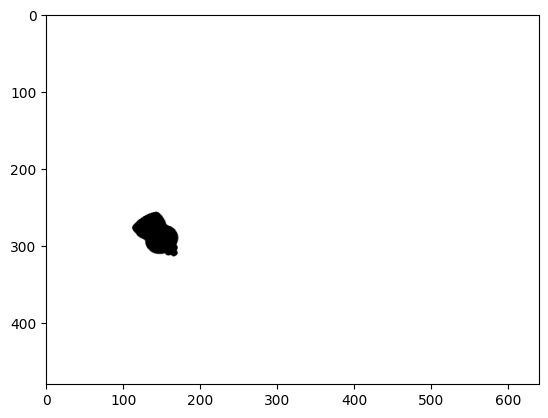

In [19]:
import numpy as np
import pyrender
import trimesh

# Load the OBJ file using trimesh
mesh = trimesh.load(obj_path)

# Create a pyrender mesh from the trimesh
pyrender_mesh = pyrender.Mesh.from_trimesh(mesh)

# Create a pyrender scene
scene = pyrender.Scene()


# Define your rotation (R) and translation (T)
# Example rotation matrix (3x3) and translation vector (3x1)
R = R_obj.detach().cpu().numpy()  # Replace with your rotation values
T = T_obj.detach().cpu().numpy()  # Replace with your translation values
cam_K = K.detach().cpu().numpy()
fx, fy = cam_K[0, 0], cam_K[1, 1]
cx, cy = cam_K[0, 2], cam_K[1, 2]

P = np.array([[1, 0, 0], [0, -1, 0], [0, 0, -1]])
# Create a transformation matrix from R and T
# The transformation matrix (4x4) for OpenGL
transform = np.eye(4)
transform[:3, :3] = np.eye(3) # Set the rotation
# Rotate the mesh by 90 degrees around the x-axis
transform[:3, :3] = P @ R
transform[:3, 3] = np.array([T[0], -T[1], -T[2]])   # Set the translation

# Create a node with the transform
node = pyrender.Node(mesh=pyrender_mesh, matrix=transform)

# Add the node to the scene
scene.add_node(node)

# Set up a camera
camera = pyrender.PerspectiveCamera(yfov=2 * np.arctan2(640, 2 * fy))  # yfov = 2 * arctan(height / (2 * focal_length))
scene.add(camera, 'camera')

# Render the scene using the pyrender viewer
# pyrender.Viewer(scene, use_raymond_lighting=True)
r = pyrender.OffscreenRenderer(640, 480)
# Render the scene from this camera pose
color, depth = r.render(scene, flags=pyrender.RenderFlags.RGBA)

plt.imshow(color)

In [7]:
#